### Modelos ARIMA

Falando de séries temporais a família de modelo ARIMA e (AR,MA, ARMA, ARIMA, SARIMA, ARIMAX, SARIMAX) são os modelos mais utilizados desta forma é necessário o conecimento de como eles funciona.

O modelo ARIMA é composto por três partes:

AR (AutoRegressivo)
I (Integração)
MA (Média Móvel)
Representados por três parâmetros inteiros: p, d e q."

1. Determinação de d (Integração): O primeiro passo na identificação do modelo é verificar se a série temporal é estacionária. Uma série é considerada estacionária se suas propriedades estatísticas, como média e variância, não mudam ao longo do tempo. Se a série não for estacionária, uma ou mais diferenciações (subtração do valor anterior) podem ser aplicadas até que a série se torne estacionária. O número de vezes que a diferenciação é aplicada é o valor de d. A estacionaridade pode ser verificada através de testes como o Teste de Dickey-Fuller Aumentado (ADF) e pela inspeção visual do gráfico da série.

2. Determinação de p (AutoRegressivo - AR): Depois de tornar a série estacionária, o próximo passo é identificar a ordem p do componente AR, que indica o número de termos defasados da própria série que são usados para prever o valor atual. A função de autocorrelação parcial (PACF) é usada para determinar p. A PACF mostra a correlação entre a série e seus valores defasados, controlando o efeito dos valores intermediários. O ponto onde a PACF corta significativamente o eixo (ou diminui para zero) sugere a ordem p.

3. Determinação de q (Média Móvel - MA): Finalmente, a ordem q do componente MA, que representa o número de termos defasados do erro, é determinada usando a função de autocorrelação (ACF). A ACF mede a correlação entre a série temporal e seus valores defasados, sem controlar pelos termos intermediários. Assim como na PACF, o ponto onde a ACF corta significativamente o eixo ou se aproxima de zero sugere a ordem q.

Com os valores de p, d e q identificados, é possível construir um modelo ARIMA que capture adequadamente a estrutura da série temporal. Em alguns casos, pode ser necessário experimentar diferentes combinações de p, d e q e avaliar o desempenho do modelo através de métricas de diagnóstico, como os resíduos e a função de informação de Akaike (AIC), para garantir que o modelo escolhido seja o mais apropriado.

### Seção 1: Importação de Bibliotecas
 
Esta seção importa todas as bibliotecas necessárias para manipulação de dados, visualização, modelagem de séries temporais e outras utilidades. Também inclui funções auxiliares para análise.

In [1]:
# Imports para manipulação de dados
import pandas as pd # Para trabalhar com DataFrames e manipulação de dados
import numpy as np  # Para operações numéricas e arrays, como np.nan
import joblib       # Para salvar e carregar modelos treinados (serialização)
import os           # Para interagir com o sistema operacional, como caminhos de arquivo
import random       # Para gerar números aleatórios
import math         # Para operações matemáticas, como math.ceil para arredondamento

# Import para tratamento de datas
from datetime import datetime, timedelta # Para manipulação de objetos de data e tempo

# Imports para visualização de dados
import matplotlib.pyplot as plt # Biblioteca padrão para criação de gráficos estáticos
import matplotlib as m          # Importa matplotlib para configurações gerais (mesmo que plt seja mais comum)
import seaborn as sns           # Para gráficos estatísticos mais atraentes e complexos

# Imports para análise e modelagem de séries temporais
import statsmodels.api as sm                                 # Biblioteca para modelos estatísticos, incluindo séries temporais
import pmdarima as pm                                        # Implementação auto_arima para seleção automática de modelos ARIMA/SARIMA
from statsmodels.graphics.tsaplots import plot_acf           # Para plotar a função de autocorrelação (ACF)
from statsmodels.graphics.tsaplots import plot_pacf          # Para plotar a função de autocorrelação parcial (PACF)
from statsmodels.tsa.stattools import adfuller               # Para realizar o Teste de Dickey-Fuller Aumentado (ADF)
from sklearn.metrics import mean_absolute_error, mean_squared_error # Métricas de avaliação de modelos (MAE, MSE)

# Filtra os warnings para não poluir a saída
import warnings
warnings.filterwarnings('ignore') # Ignora avisos, o que pode ser útil em notebooks, mas deve ser usado com cautela em produção

### Seção 2: Funções
 
Esta seção gera as funções criadas para serem utilizadas neste código.


In [2]:
'''
Dando os devidos créditos:
Esta função foi recebida no curso de Modelagem de Séries Temporais e Real-Time Analytics 
com Apache Spark e Databricks oferecido pela DSA - Data Science Academy
'''

# Função para testar a estacionaridade de uma série temporal
def dsa_testa_estacionaridade(serie, window = 12, title = 'Estatísticas Móveis e Teste Dickey-Fuller'):
    """
    Função para testar a estacionaridade de uma série temporal.
    
    A estacionaridade é uma propriedade crucial em séries temporais, indicando que as propriedades
    estatísticas da série (média, variância, autocorrelação) não mudam ao longo do tempo.
    Modelos ARIMA assumem estacionaridade.

    Parâmetros:
    - serie: pandas.Series. Série temporal a ser testada.
    - window: int. Janela para cálculo das estatísticas móveis (média e desvio padrão).
                   Um valor comum para dados diários com sazonalidade mensal é 30 ou 90.
                   Para sazonalidade anual, pode ser 12 (meses) ou 365 (dias).
    - title: str. Título para os gráficos.
    """
    # Calcula estatísticas móveis: média móvel e desvio padrão móvel
    # Se a série for estacionária, essas linhas devem ser aproximadamente constantes.
    rolmean = serie.rolling(window = window).mean()
    rolstd = serie.rolling(window = window).std()

    # Plot das estatísticas móveis junto com a série original
    plt.figure(figsize = (14, 6)) # Define o tamanho da figura
    plt.plot(serie, color = 'blue', label = 'Original') # Plota a série original
    plt.plot(rolmean, color = 'red', label = 'Média Móvel') # Plota a média móvel
    plt.plot(rolstd, color = 'black', label = 'Desvio Padrão Móvel') # Plota o desvio padrão móvel
    plt.legend(loc = 'best') # Exibe a legenda na melhor posição
    plt.title(title) # Define o título do gráfico
    plt.show(block = False) # Exibe o gráfico sem bloquear a execução do código

    # Realiza o Teste de Dickey-Fuller Aumentado (ADF) para formalizar o teste de estacionaridade
    print('\nResultado do Teste Dickey-Fuller:')
    dfteste = adfuller(serie, autolag = 'AIC') # autolag='AIC' permite que a função escolha o número de lags otimamente
    
    # Organiza os resultados do teste em uma série pandas para melhor visualização
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                               'Valor-p',
                                               'Número de Lags Consideradas',
                                               'Número de Observações Usadas'])
    # Adiciona os valores críticos do teste
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)' % key] = value
        
    print(dfsaida)
    
    # Interpretação da conclusão do teste com base no valor-p
    # Hipótese Nula (H0): A série não é estacionária (possui raiz unitária).
    # Hipótese Alternativa (H1): A série é estacionária.
    if dfsaida['Valor-p'] > 0.05:
        print('\nConclusão:\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.\nEssa série provavelmente não é estacionária.')
    else:
        print('\nConclusão:\nO valor-p é menor que 0.05 e, portanto,temos evidências para rejeitar a hipótese nula.\nEssa série provavelmente é estacionária.')


In [3]:
# Função auxiliar para criar uma lista de valores decimais com uma probabilidade específica de ser zero
def criar_lista_com_probabilidade_zero(tamanho_lista, probabilidade_zero=0.70, valor_min_nao_zero=0.001, valor_max_nao_zero=15.0):
    """
    Cria uma lista de valores decimais onde uma porcentagem específica dos valores é 0.
    Útil para simular dados esparsos ou com alta frequência de um determinado valor (zero neste caso).

    Args:
        tamanho_lista (int): O número total de elementos na lista.
        probabilidade_zero (float): A probabilidade (entre 0 e 1) de um valor ser 0.
        valor_min_nao_zero (float): O valor mínimo para os números não-zero (exclusivo).
                                    Usado para garantir que os números não-zero sejam > 0.
        valor_max_nao_zero (float): O valor máximo para os números não-zero (inclusive).

    Returns:
        list: Uma lista de floats com a distribuição especificada.
    """
    # Valida se a probabilidade está dentro do intervalo esperado
    if not (0 <= probabilidade_zero <= 1):
        raise ValueError("A probabilidade de zero deve estar entre 0 e 1.")
    # Retorna uma lista vazia se o tamanho for 0 ou negativo
    if tamanho_lista <= 0:
        return []

    # Calcula o número de zeros e de valores não-zero, arredondando o número de zeros para cima
    # para garantir que a proporção mínima seja atendida.
    num_zeros = math.ceil(tamanho_lista * probabilidade_zero)
    num_nao_zeros = tamanho_lista - num_zeros

    lista_final = []

    # Adiciona os zeros à lista
    lista_final.extend([0.0] * num_zeros)

    # Adiciona os números não-zero aleatórios.
    # random.uniform(a, b) gera um float N tal que a <= N <= b.
    # Definimos um 'valor_min_nao_zero' pequeno (mas > 0) para evitar que valores gerados
    # por uniform() sejam exatamente 0, distinguindo-os dos zeros intencionais.
    for _ in range(num_nao_zeros):
        lista_final.append(random.uniform(valor_min_nao_zero, valor_max_nao_zero))

    # Embaralha a lista para distribuir aleatoriamente os zeros e os números não-zero.
    random.shuffle(lista_final)

    return lista_final

### Seção 3: Carregamento e Pré-processamento dos Dados

Aqui, o dataset é carregado, o formato da coluna de data é ajustado e a data é definida como índice do DataFrame.


In [4]:
# Define o diretório onde o dataset está localizado e o nome do arquivo
datasets_dir = os.path.join('..', 'Datasets') # Caminho relativo para a pasta 'Datasets'
filename = 'Consumo_cerveja.csv'              # Nome do arquivo CSV
full_path = os.path.join(datasets_dir, filename) # Caminho completo para o arquivo

In [5]:
# Carrega o dataset do arquivo CSV para um DataFrame pandas
dados = pd.read_csv(full_path)

In [6]:
# Exibe informações sobre o DataFrame, incluindo tipos de dados e valores não nulos
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Data                         365 non-null    object 
 1   Temperatura Media (C)        365 non-null    float64
 2   Temperatura Minima (C)       365 non-null    float64
 3   Temperatura Maxima (C)       365 non-null    float64
 4   Precipitacao (mm)            365 non-null    float64
 5   Final de Semana              365 non-null    int64  
 6   Consumo de cerveja (litros)  365 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 20.1+ KB


In [7]:
# Exibe as primeiras linhas do DataFrame para inspeção visual
dados

,Data,Temperatura Media (C),Temperatura Minima (C),Temperatura Maxima (C),Precipitacao (mm),Final de Semana,Consumo de cerveja (litros)
0,01/01/2015,27.30,23.9,32.5,0.0,0,25.461
1,02/01/2015,27.02,24.5,33.5,0.0,0,28.972
2,03/01/2015,24.82,22.4,29.9,0.0,1,30.814
3,04/01/2015,23.98,21.5,28.6,1.2,1,29.799
4,05/01/2015,23.82,21.0,28.3,0.0,0,28.900
...,...,...,...,...,...,...,...
360,27/12/2015,24.00,21.1,28.2,13.6,1,32.307
361,28/12/2015,22.64,21.1,26.7,0.0,0,26.095
362,29/12/2015,21.68,20.3,24.1,10.3,0,22.309
363,30/12/2015,21.38,19.3,22.4,6.3,0,20.467


In [8]:
# Converte a coluna 'Data' para o tipo datetime, especificando o formato original
dados['Data'] = pd.to_datetime(dados['Data'], format='%d/%m/%Y')

# Define a coluna 'Data' como o índice do DataFrame.
# 'inplace=True' modifica o DataFrame diretamente sem a necessidade de reatribuição.
dados.set_index('Data',inplace=True)

# Exibe informações atualizadas sobre o DataFrame para confirmar a mudança no índice
dados.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2015-01-01 to 2015-12-31
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Temperatura Media (C)        365 non-null    float64
 1   Temperatura Minima (C)       365 non-null    float64
 2   Temperatura Maxima (C)       365 non-null    float64
 3   Precipitacao (mm)            365 non-null    float64
 4   Final de Semana              365 non-null    int64  
 5   Consumo de cerveja (litros)  365 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 20.0 KB


### Seção 4: Análise de Variáveis Exógenas e Multicolinearidade

Esta seção aborda o conceito de variáveis exógenas e a importância de analisar a multicolinearidade entre elas, especialmente para modelos SARIMAX.


### Variáveis Exógenas

Uma variável exógena é uma variável que influencia o modelo, mas não é influenciada por ele. Em outras palavras, essas variáveis vêm de fora do sistema modelado e são consideradas independentes do processo gerador da série temporal em análise.

Elas podem capturar fatores externos que impactam diretamente a variável dependente ou a série temporal de interesse


ARIMAX (Autoregressive Integrated Moving Average with Exogenous Variables) é uma extensão do modelo ARIMA que incorpora variáveis exógenas (ou seja, variáveis externas ou independentes) no processo de previsão. Além de considerar os componentes autoregressivo, de diferenciação e de média móvel (ARIMA), o ARIMAX também leva em conta o impacto de uma ou mais variáveis externas sobre a série temporal, tornando-o útil quando fatores externos influenciam os dados.

SARIMAX (Seasonal ARIMAX) é uma extensão do ARIMAX que, além de incorporar variáveis exógenas, também considera componentes sazonais. Ele combina as funcionalidades do SARIMA (que lida com a sazonalidade) e do ARIMAX (que incorpora variáveis exógenas), sendo adequado para modelar séries temporais que são afetadas por fatores externos e que apresentam padrões sazonais

### Multicolinearidade

Multicolinearidade ocorre quando duas ou mais variáveis independentes em um modelo de regressão estão altamente orrelacionadas entre si.

Estudar a correlação das variáveis exógenas é crucial por vários motivos, que se ligam diretamente aos problemas da multicolinearidade:

1.  **Melhor Interpretação do Modelo:**
    *   Os coeficientes dos regressores (as variáveis exógenas) podem ser difíceis de interpretar se houver alta correlação. Se você quer entender qual variável exógena está contribuindo mais ou como cada uma influencia sua série temporal, evitar a multicolinearidade é chave.
    *   Para tomar decisões baseadas nos insights do modelo (ex: "se aumentarmos a publicidade online, as vendas aumentarão em X"), você precisa confiar nos coeficientes. A com multicolinearidade se perode essa confiança.

2.  **Seleção de Features (Variáveis):**
    *   Se duas variáveis exógenas são altamente correlacionadas, elas provavelmente estão fornecendo informações muito semelhantes ao modelo. Incluir ambas pode ser redundante.
    *   Ao identificar variáveis correlacionadas, você pode decidir remover uma delas, reduzir a dimensionalidade, ou combiná-las em uma única variável composta (ex: um índice). Um modelo mais simples é geralmente mais fácil de manter e mais eficiente computacionalmente.
    *   Permite focar nas variáveis exógenas que trazem informações *únicas* e valiosas para o modelo.

3.  **Qualidade dos Dados para Previsão Futura:**
    *   Pprever os valores futuros das variáveis exógenas é um desafio. Se você tem duas variáveis exógenas altamente correlacionadas (`exogA` e `exogB`), e você precisa prever ambas para o futuro, está dobrando o trabalho. Se você puder usar apenas `exogA` (e remover `exogB` devido à alta correlação), você reduz a complexidade e a incerteza associadas à previsão de uma das exógenas para o período futuro.

4.  **Identificação de Relações Espúrias ou Indiretas:**
    *   Às vezes, uma variável exógena parece ter um forte impacto em `y`, mas essa relação é, na verdade, um reflexo da forte correlação dessa exógena com uma *outra* variável que é a verdadeira causadora. Exemplo: Vendas de sorvete (`y`) são altas com "número de óculos de sol vendidos" (`exog1`), mas a correlação real é que ambos estão relacionados à "temperatura ambiente" (`exog2`). Se `exog1` e `exog2` são altamente correlacionadas, você pode acabar interpretando mal o impacto de `exog1`.
    *   Para ver exemplos de relações sem sentido: https://www.tylervigen.com/spurious-correlations
	
Para detectar a multicolinearidade em geral utiliza-se o método de Pearson entre todas as suas variáveis exógenas. Valores próximos de +1 ou -1 indicam forte correlação.

Após a avaliação descartanos as variáves desnecessárias.

In [9]:
# Calcula a matriz de correlação de todas as variáveis numéricas no DataFrame 'dados'.
# Isso ajuda a entender as relações entre as variáveis, incluindo a multicolinearidade.
dados.corr()

,Temperatura Media (C),Temperatura Minima (C),Temperatura Maxima (C),Precipitacao (mm),Final de Semana,Consumo de cerveja (litros)
Temperatura Media (C),1.000000,0.862752,0.922513,0.024416,-0.050803,0.574615
Temperatura Minima (C),0.862752,1.000000,0.672929,0.098625,-0.059534,0.392509
Temperatura Maxima (C),0.922513,0.672929,1.000000,-0.049305,-0.040258,0.642672
Precipitacao (mm),0.024416,0.098625,-0.049305,1.000000,0.001587,-0.193784
Final de Semana,-0.050803,-0.059534,-0.040258,0.001587,1.000000,0.505981
Consumo de cerveja (litros),0.574615,0.392509,0.642672,-0.193784,0.505981,1.000000


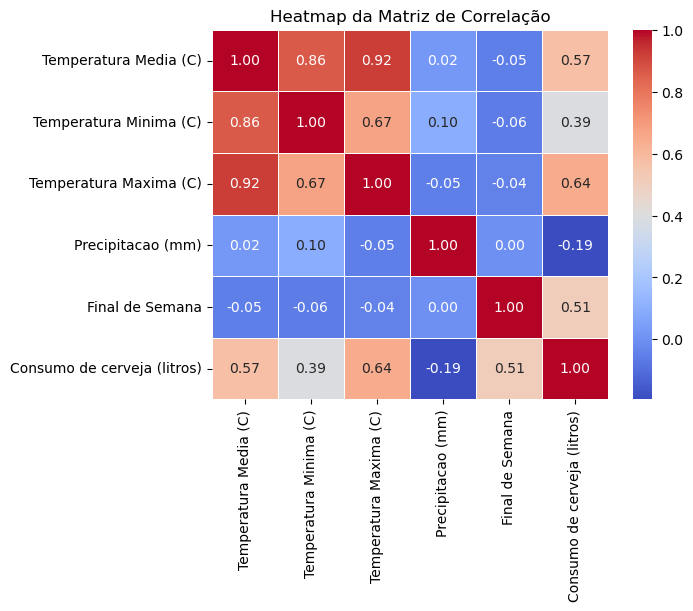

In [10]:
# Cria um heatmap da matriz de correlação para uma visualização clara das relações
sns.heatmap(
    dados.corr(numeric_only=True), # Calcula a correlação e garante que apenas colunas numéricas são usadas
    annot=True,      # Mostra os valores de correlação nas células do heatmap
    cmap='coolwarm', # Usa um mapa de cores divergente ('coolwarm') que é bom para correlações (positivo/negativo)
    fmt=".2f",       # Formata os números de correlação para duas casas decimais
    linewidths=.5    # Adiciona linhas para separar visualmente as células, melhorando a legibilidade
)
plt.title('Heatmap da Matriz de Correlação') # Adiciona um título ao gráfico
plt.show() # Exibe o gráfico do heatmap


In [11]:
# Seleciona a coluna de interesse para a série temporal endógena (variável dependente)
df_endo = dados[['Consumo de cerveja (litros)']]

# Renomeia a coluna para 'consumo' para facilitar o uso no modelo
df_endo.columns = ['consumo']

In [12]:
# Seleciona as variáveis exógenas (independentes) que influenciarão o modelo
# Observe que foram excluidas as variáveis com alta correlação
df_exog = dados[['Temperatura Maxima (C)','Precipitacao (mm)','Final de Semana']]

# Renomeia as colunas exógenas para nomes mais curtos e convenientes
df_exog.columns=['temp','chuva','fds']

### Seção 5: Análise de Estacionaridade e Decomposição de Séries Temporais

Aqui, a estacionaridade da série endógena e das exógenas é testada, e a série endógena é decomposta para observar tendência, sazonalidade e resíduos.


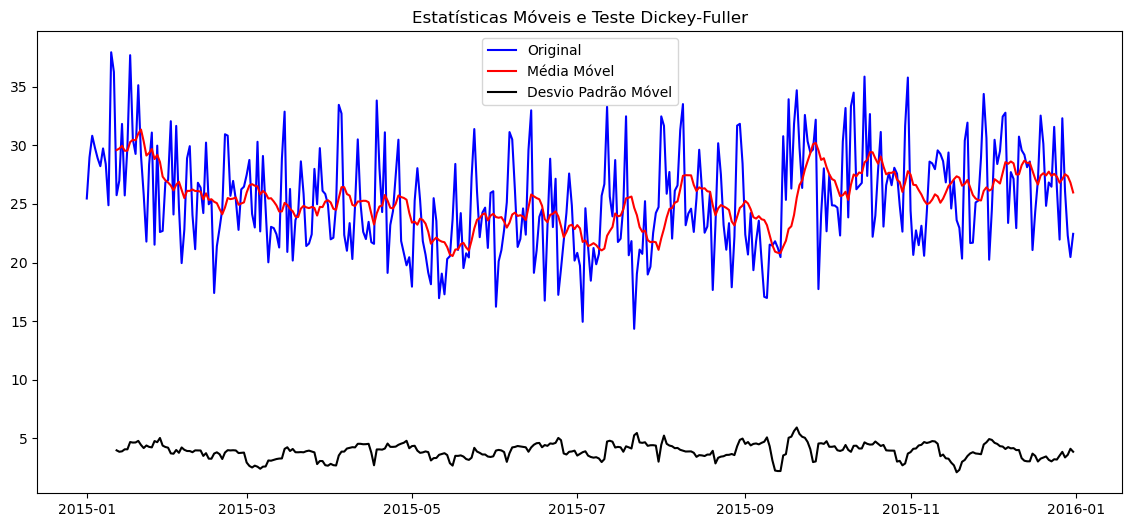


Resultado do Teste Dickey-Fuller:
Estatística do Teste             -3.465884
Valor-p                           0.008908
Número de Lags Consideradas      13.000000
Número de Observações Usadas    351.000000
Valor Crítico (1%)               -3.449119
Valor Crítico (5%)               -2.869810
Valor Crítico (10%)              -2.571176
dtype: float64

Conclusão:
O valor-p é menor que 0.05 e, portanto,temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [13]:
# Testa a estacionaridade da série temporal endógena ('consumo')
# Uma série estacionária tem média, variância e estrutura de autocorrelação constantes ao longo do tempo.
# Isso é um pré-requisito para muitos modelos de séries temporais, incluindo o ARIMA.
dsa_testa_estacionaridade(df_endo)

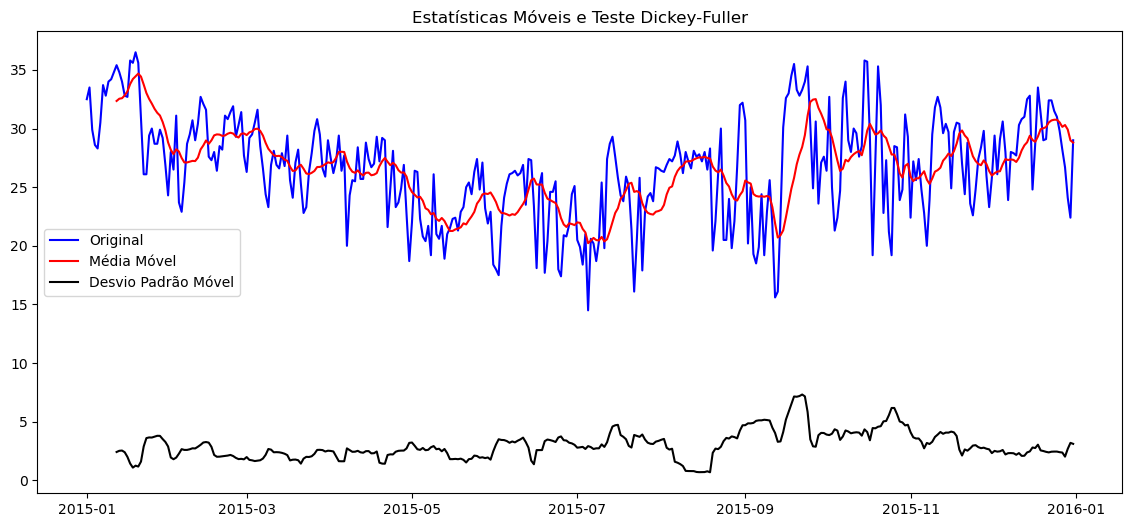


Resultado do Teste Dickey-Fuller:
Estatística do Teste             -5.537227
Valor-p                           0.000002
Número de Lags Consideradas       2.000000
Número de Observações Usadas    362.000000
Valor Crítico (1%)               -3.448544
Valor Crítico (5%)               -2.869557
Valor Crítico (10%)              -2.571041
dtype: float64

Conclusão:
O valor-p é menor que 0.05 e, portanto,temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [14]:
# Testa a estacionaridade da variável exógena 'temp' (Temperatura Máxima)
dsa_testa_estacionaridade(df_exog['temp'])

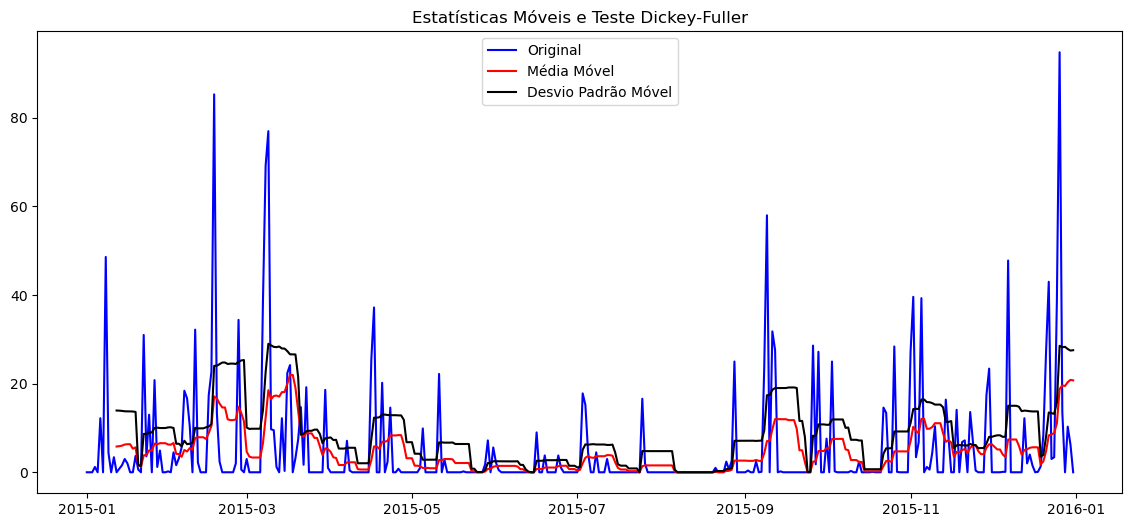


Resultado do Teste Dickey-Fuller:
Estatística do Teste           -1.379192e+01
Valor-p                         8.893576e-26
Número de Lags Consideradas     0.000000e+00
Número de Observações Usadas    3.640000e+02
Valor Crítico (1%)             -3.448443e+00
Valor Crítico (5%)             -2.869513e+00
Valor Crítico (10%)            -2.571018e+00
dtype: float64

Conclusão:
O valor-p é menor que 0.05 e, portanto,temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [15]:
# Testa a estacionaridade da variável exógena 'chuva' (Precipitação)
dsa_testa_estacionaridade(df_exog['chuva'])

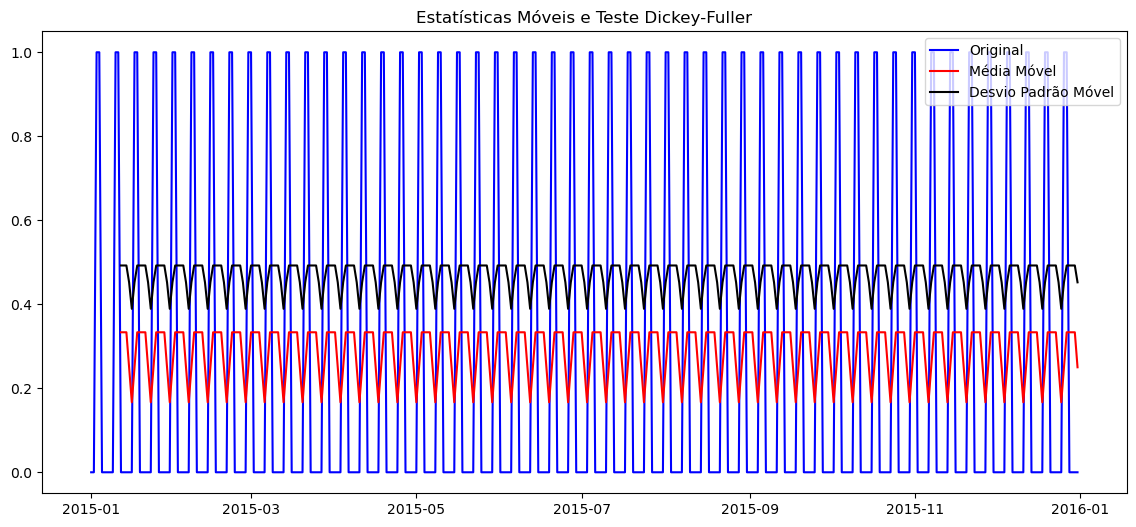


Resultado do Teste Dickey-Fuller:
Estatística do Teste           -7.964278e+15
Valor-p                         0.000000e+00
Número de Lags Consideradas     7.000000e+00
Número de Observações Usadas    3.570000e+02
Valor Crítico (1%)             -3.448801e+00
Valor Crítico (5%)             -2.869670e+00
Valor Crítico (10%)            -2.571101e+00
dtype: float64

Conclusão:
O valor-p é menor que 0.05 e, portanto,temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [16]:
# Testa a estacionaridade da variável exógena 'fds' (Final de Semana)
# Variáveis categóricas ou binárias geralmente são estacionárias, mas a verificação é boa prática.
dsa_testa_estacionaridade(df_exog['fds'])

In [17]:
# Realiza a decomposição da série temporal endógena para identificar tendência, sazonalidade e resíduo.
# 'multiplicative' é usado quando a magnitude dos componentes sazonais ou de tendência aumenta com a série.
# 'extrapolate_trend = 'freq'' ajuda a lidar com valores NaN no início/fim da tendência.
decomposicao_multiplicativa = sm.tsa.seasonal_decompose(df_endo, 
                                                        model = 'multiplicative', 
                                                        extrapolate_trend = 'freq')

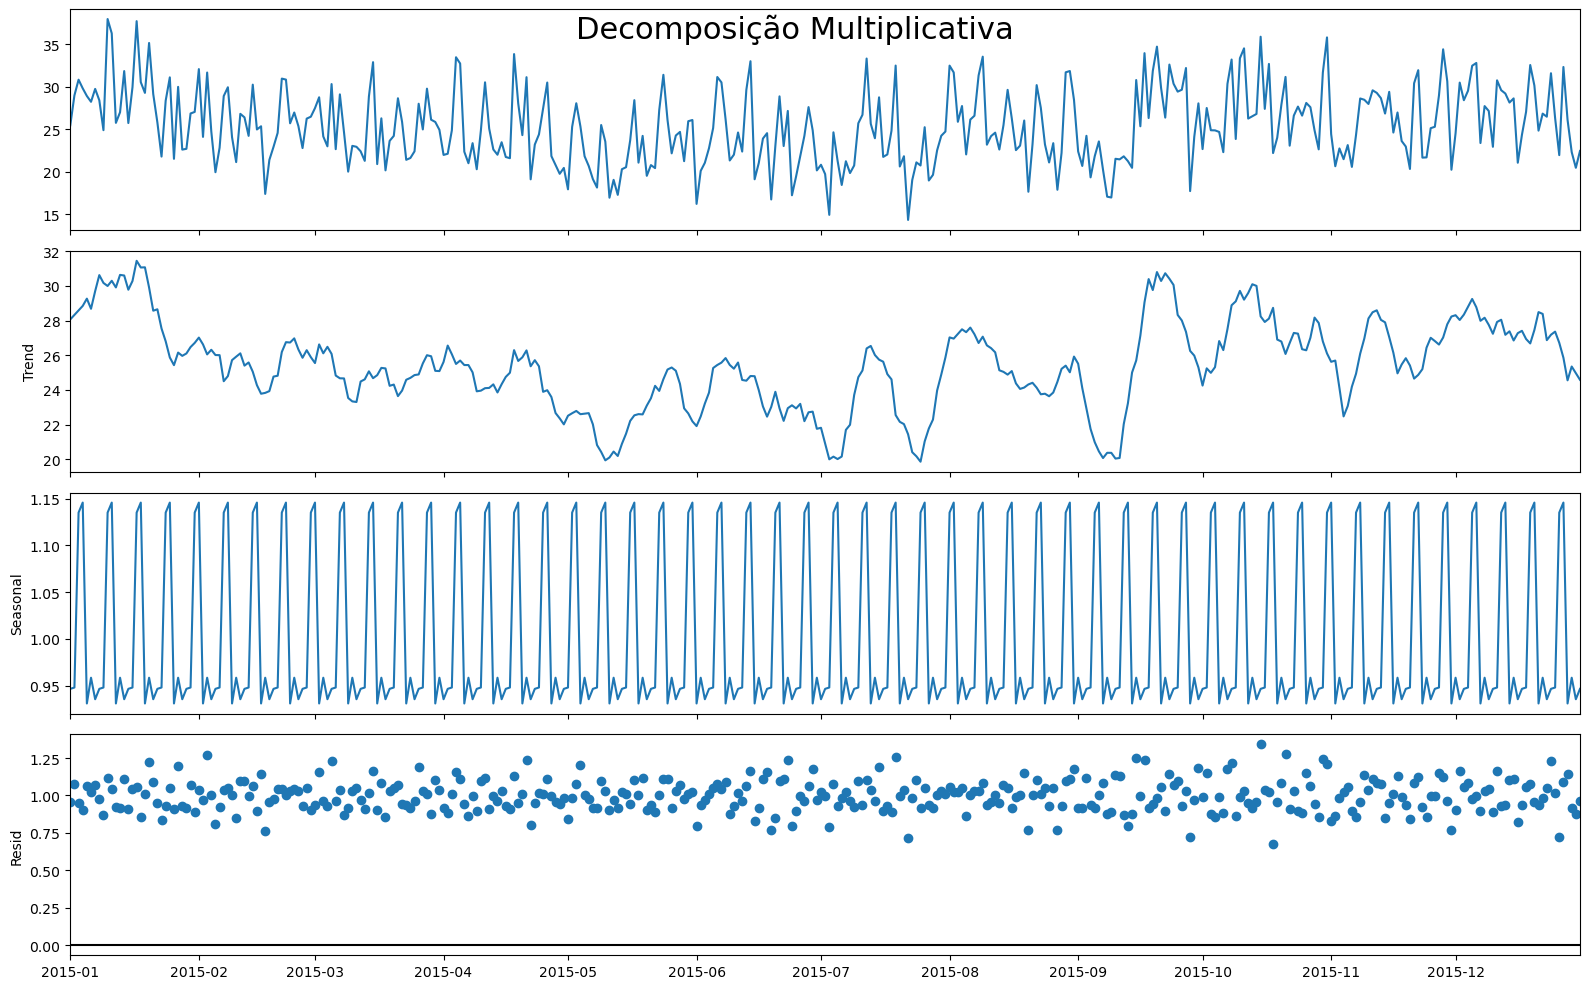

In [18]:
# Plota os componentes da decomposição (observado, tendência, sazonalidade, resíduo)
plt.rcParams.update({'figure.figsize': (16,10)}) # Define o tamanho padrão das figuras
decomposicao_multiplicativa.plot().suptitle('Decomposição Multiplicativa', fontsize = 22) # Plota e adiciona título principal
plt.show() # Exibe os gráficos

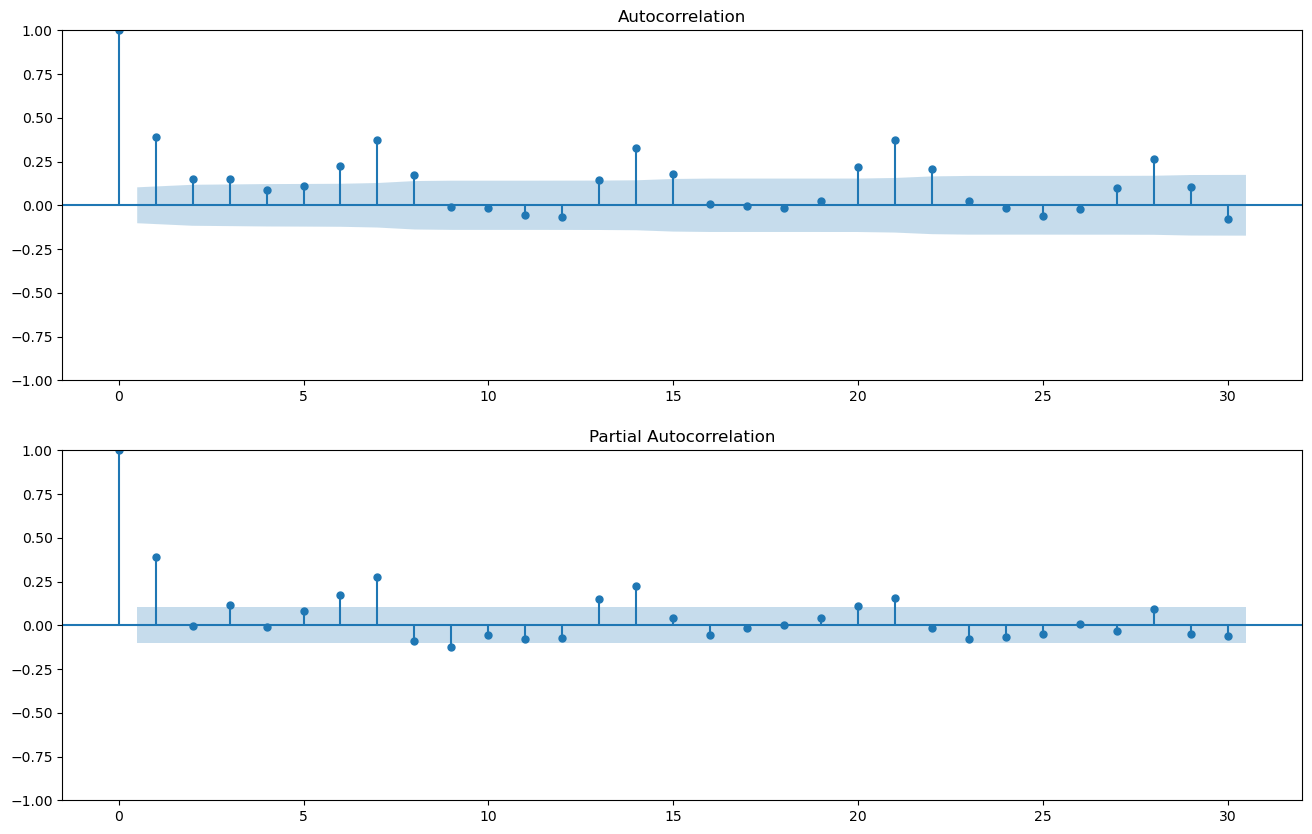

In [19]:
# Plota os a saída dos teste ACP e PACF

# Plots
plt.rcParams.update({'figure.figsize': (16,10)})

# Plot do gráfico ACF
plt.subplot(211)
plot_acf(df_endo, ax = plt.gca(), lags = 30)

# Plot do gráfico PACF
plt.subplot(212)
plot_pacf(df_endo, ax = plt.gca(), lags = 30, method = 'ywm')
plt.show()

### Seção 6: Divisão dos Dados e Treinamento do Modelo SARIMAX

Nesta seção, os dados são divididos em conjuntos de treino e teste, e o modelo SARIMAX é treinado usando `pmdarima.auto_arima` para encontrar a melhor combinação de parâmetros.


In [20]:
# Divide o DataFrame em conjuntos de treino e teste.
# 80% dos dados são usados para treino e 20% para teste, o que é uma prática comum em séries temporais.
tam = int(len(df_endo) * 0.8) # Calcula o índice para a divisão (80% do total)

y_train = df_endo[:tam]  # Variável endógena (consumo) para treino
y_test = df_endo[tam:]   # Variável endógena (consumo) para teste

X_train = df_exog[:tam]  # Variáveis exógenas (temp, chuva, fds) para treino
X_test = df_exog[tam:]   # Variáveis exógenas (temp, chuva, fds) para teste

In [21]:
# Treina um modelo SARIMAX automaticamente usando pmdarima.auto_arima
# auto_arima busca a melhor combinação (p,d,q)(P,D,Q,s) e parâmetros para o modelo.
modelo_sarimax = pm.auto_arima(y_train,               # Série temporal endógena para treino
                                exogenous = X_train, # Variáveis exógenas para treino
                                seasonal = True,     # Indica que a série possui componente sazonal
                                m = 12,              # Período da sazonalidade (12 para dados mensais/anuais, ou 7 para semanais)
                                start_p = 0,         # Ordem inicial para o componente AR não-sazonal
                                start_d = 0,         # Ordem inicial para a diferenciação não-sazonal
                                start_q = 0,         # Ordem inicial para o componente MA não-sazonal
                                max_p = 15,          # Ordem máxima para o componente AR não-sazonal
                                max_d = 15,          # Ordem máxima para a diferenciação não-sazonal
                                max_q = 15,          # Ordem máxima para o componente MA não-sazonal
                                start_P = 0,         # Ordem inicial para o componente AR sazonal
                                start_D = 0,         # Ordem inicial para a diferenciação sazonal
                                start_Q = 0,         # Ordem inicial para o componente MA sazonal
                                max_P = 15,          # Ordem máxima para o componente AR sazonal
                                max_D = 15,          # Ordem máxima para a diferenciação sazonal
                                max_Q = 15,          # Ordem máxima para o componente MA sazonal
                                # max_order = 10,  # Limite máximo para a soma de p,q,P,Q (descomentar se necessário)
                                information_criterion = 'aic', # Critério de informação para seleção do melhor modelo (AIC, BIC, HQIC, OOB)
                                trace = True,        # Mostra o progresso da busca do modelo
                                stepwise = False,    # Se True, usa uma abordagem mais rápida, mas menos exaustiva de busca
                                error_action = 'ignore') # Ignora erros que possam ocorrer durante a busca de modelos


 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1758.918, Time=0.02 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1752.210, Time=0.09 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=1754.145, Time=0.22 sec
 ARIMA(0,1,0)(0,0,3)[12] intercept   : AIC=1752.783, Time=0.49 sec
 ARIMA(0,1,0)(0,0,4)[12] intercept   : AIC=1751.880, Time=1.05 sec
 ARIMA(0,1,0)(0,0,5)[12] intercept   : AIC=1745.045, Time=2.63 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1752.401, Time=0.09 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1751.064, Time=0.29 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=1756.208, Time=0.27 sec
 ARIMA(0,1,0)(1,0,3)[12] intercept   : AIC=1752.146, Time=1.13 sec
 ARIMA(0,1,0)(1,0,4)[12] intercept   : AIC=1750.936, Time=2.27 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=1754.355, Time=0.21 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(0,1,0)(2,0,3)[12] intercept   : AIC=inf, Time=3.00 sec
 ARIMA(0,1

In [22]:
# Exibe o sumário do modelo SARIMAX treinado, que inclui parâmetros, coeficientes,
# estatísticas de significância, e métricas como AIC, BIC, etc.
print(modelo_sarimax.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  292
Model:             SARIMAX(1, 1, 1)x(0, 0, 1, 12)   Log Likelihood                -814.795
Date:                            Tue, 25 Nov 2025   AIC                           1639.590
Time:                                    09:45:09   BIC                           1657.956
Sample:                                01-01-2015   HQIC                          1646.947
                                     - 10-19-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0040      0.015     -0.261      0.794      -0.034       0.026
ar.L1          0.2248      0.078   

### Seção 7: Avaliação do Modelo
 
Esta seção calcula as previsões nos conjuntos de treino e teste e avalia o desempenho do modelo usando as métricas MAE (Mean Absolute Error) e MSE (Mean Squared Error).


In [23]:
# Realiza previsões nos dados de treino (in-sample) usando o modelo treinado.
# Isso permite verificar o quão bem o modelo se ajusta aos dados que ele já "viu".
previsoes_treino = modelo_sarimax.predict_in_sample(exogenous = X_train)

In [24]:
# Calcula o Erro Absoluto Médio (MAE) e o Erro Quadrático Médio (MSE) para os dados de treino.
# MAE: Média dos valores absolutos dos erros. Mais interpretável, na mesma unidade da variável.
# MSE: Média dos erros ao quadrado. Penaliza erros maiores, mais sensível a outliers.
mae_train = mean_absolute_error(y_train, previsoes_treino)
mse_train = mean_squared_error(y_train, previsoes_treino)
print(f'Mean Absolute Error (MAE) com dados de treino: {mae_train:.2f}')
print(f'Mean Squared Error (MSE) com dados de treino: {mse_train:.2f}')

Mean Absolute Error (MAE) com dados de treino: 3.24
Mean Squared Error (MSE) com dados de treino: 17.98


In [25]:
# Realiza previsões nos dados de teste (out-of-sample) usando o modelo treinado.
# auto_modelo_dsa não foi definido, assumindo que deveria ser `modelo_sarimax`
# Previsões para o futuro usando os dados de teste para as variáveis exógenas.
previsoes_teste = modelo_sarimax.predict(n_periods = len(y_test), exogenous = X_test)

In [26]:
# Calcula o MAE e o MSE para os dados de teste.
# Estas métricas são mais importantes pois indicam a capacidade de generalização do modelo para dados não vistos.
mae_test = mean_absolute_error(y_test, previsoes_teste)
mse_test = mean_squared_error(y_test, previsoes_teste)
print(f'Mean Absolute Error (MAE) com dados de teste: {mae_test:.2f}')
print(f'Mean Squared Error (MSE) com dados de teste: {mse_test:.2f}')

Mean Absolute Error (MAE) com dados de teste: 3.15
Mean Squared Error (MSE) com dados de teste: 13.83


In [27]:
# Reajusta o modelo SARIMAX usando todos os dados disponíveis (treino + teste).
# Isso é feito para preparar o modelo para realizar previsões futuras com base em todo o histórico de dados.
modelo_sarimax.fit(df_endo, exogenous = df_exog)

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(0, 0, 1, 12),
      suppress_warnings=True)

### Seção 8: Previsão Futura
 
Esta seção gera um DataFrame com dados futuros para as variáveis exógenas e usa o modelo reajustado para prever o consumo de cerveja para os próximos 7 dias.


In [28]:
# --- Construção do DataFrame de Variáveis Exógenas Futuras ---
# Esta etapa é crucial para modelos ARIMAX/SARIMAX, pois eles exigem os valores futuros
# das variáveis exógenas para fazer previsões da variável endógena.

In [29]:
# 1. Determina a data de início para a previsão futura (um dia após a última data do DataFrame original)
data_inicio_previsao = df_endo.index.max() + pd.Timedelta(days=1)
# Converte a data de início para o formato de string dd/mm/yyyy para ser usada em pd.date_range
data_inicio_previsao_str = data_inicio_previsao.strftime('%d/%m/%Y')

num_dias_futuro = 7 # Define o número de dias para os quais queremos prever

In [30]:
# 2. Cria o índice temporal para o período futuro
# 'D' especifica frequência diária.
indice_temporal_futuro = pd.date_range(start=data_inicio_previsao_str, periods=num_dias_futuro, freq='D')

In [31]:
# 3. Cria a coluna 'fds' (Final de Semana) para o período futuro
# Identifica se cada dia no índice futuro é um fim de semana (Sábado ou Domingo)
# .weekday() retorna 0 para segunda-feira e 6 para domingo.
# Fim de semana é quando .weekday() é >= 5 (Sábado=5, Domingo=6).
fim_de_semana_coluna_futura = [(1 if data.weekday() >= 5 else 0) for data in indice_temporal_futuro]

# 4. Inicializa o DataFrame de variáveis exógenas futuras com o índice e a coluna 'fds'
df_futuro_exog = pd.DataFrame(
    {'fds': fim_de_semana_coluna_futura}, # 'fds' já preenchida
    index=indice_temporal_futuro           # Índice temporal futuro
)

In [32]:
# Simula os valores futuros da temperatura ('temp') para os próximos 7 dias.
# np.random.normal(loc, scale, size) gera números aleatórios de uma distribuição normal.
# loc: média, scale: desvio padrão, size: número de amostras.
# .reshape(-1, 1) garante que o array tenha a forma correta para ser uma coluna.
# Aqui, a temperatura futura é simulada com uma média de 20 e desvio padrão de 5.
df_futuro_exog['temp'] = np.random.normal(loc = 20, scale = 5, size = num_dias_futuro)

In [33]:
# Gera os valores futuros de precipitação ('chuva') usando a função auxiliar personalizada.
# A função 'criar_lista_com_probabilidade_zero' gera valores decimais entre 0 e 15,
# com 70% de chance de serem 0 (simulando dias sem chuva).
df_futuro_exog['chuva'] = criar_lista_com_probabilidade_zero(num_dias_futuro)

In [34]:
# Reordena as colunas do DataFrame de exógenas futuras para que correspondam
# à ordem usada durante o treinamento do modelo ('temp', 'chuva', 'fds').
# Isso é essencial para que o modelo interprete corretamente as variáveis.
df_futuro_exog = df_futuro_exog[['temp','chuva','fds']]

In [35]:
# Exibe o DataFrame de variáveis exógenas futuras para verificar os dados
df_futuro_exog

,temp,chuva,fds
2016-01-01,15.060129,0.000000,0
2016-01-02,23.968309,0.000000,1
2016-01-03,19.182206,0.000000,1
2016-01-04,18.129658,0.000000,0
2016-01-05,12.334954,4.088663,0
2016-01-06,11.928839,9.716026,0
2016-01-07,24.807562,0.000000,0


In [36]:
# Gera previsões futuras do consumo de cerveja usando o modelo SARIMAX reajustado.
# n_periods: Número de passos de tempo para prever no futuro (7 dias).
# exogenous: O DataFrame contendo os valores futuros das variáveis exógenas.
# return_conf_int: Se True, retorna também os intervalos de confiança da previsão.
pred_forecast = modelo_sarimax.predict(n_periods = num_dias_futuro, 
                                       exogenous = df_futuro_exog, 
                                       return_conf_int = True)

In [37]:
# Exibe as previsões futuras, incluindo o valor previsto e os intervalos de confiança.
# O intervalo de confiança dá uma estimativa da incerteza da previsão.
print("Previsões para os próximos 7 dias (valor previsto, limite inferior, limite superior):")
print(pred_forecast)

Previsões para os próximos 7 dias (valor previsto, limite inferior, limite superior):
(2016-01-01    24.803702
2016-01-02    26.616197
2016-01-03    26.428212
2016-01-04    26.084233
2016-01-05    25.046106
2016-01-06    26.339246
2016-01-07    27.421834
Freq: D, dtype: float64, array([[17.17363567, 32.43376814],
       [18.61908495, 34.61330841],
       [18.35600803, 34.50041667],
       [17.9746788 , 34.19378629],
       [16.90657681, 33.18563475],
       [18.17151085, 34.50698189],
       [19.22639156, 35.61727732]]))
